MLP with Batch Normalization

* simple building block to ensure well-behaved pre-activations after linear layer (instead of hand-tuning some gains for linear layer weights at initialization)
    * standard Gaussian: not too low - low activation, not too high - no gradient flow
* creates coupling between samples within a batch (undesirable) but also acts as regularizer (+)
    * previously, samples were processed in batches for efficiency but computations were independent
    * some alternatives to reduce coupling but this has still remained around even though it can become source of many bugs

IMPL - BatchNorm layer 
* learns gain and bias parameters and buffers running mean/std estimates during training to use during inference for individual samples
    * linear layer bias just gets normalized away so can be removed (`bias=False`)
    * buffers estimates instead of additional explicit calibration step post-training
* Hyperparameters: 
    * momentum: smaller batch size -> batch var larger -> high momentum creates thrashing (difficult to converge)

In [1]:
import random

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt  # for making figures

%matplotlib inline

In [2]:
# same as part 1

# load raw data: 32_033 names, length in [2, 15]
words = open("names.txt", "r").read().splitlines()

# build char vocabulary and tokenizer
chars = sorted(set("".join(words)))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(f"{vocab_size=}\nencoder {stoi=}\ndecoder {itos=}")

vocab_size=27
encoder stoi={'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
decoder itos={1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [3]:
# same as part 2: prep the dataset
block_size = (
    3  # context length: how many characters do we take to predict the next one?
)


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size  # encoded sequence "..."
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])  # 80% training
Xdev, Ydev = build_dataset(words[n1:n2])  # 10% dev
Xte, Yte = build_dataset(words[n2:])  # 10% test

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# MLP Revisited: Single Hidden Layer

In [4]:
# Initialize parameters

n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = (
    torch.randn((n_embd * block_size, n_hidden), generator=g)
    * (5 / 3)
    / ((n_embd * block_size) ** 0.5)
)  # kaiming normal scaling factor
# b1 no longer a useful parameter
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))  # buffer to use for inference, not learned
bnstd_running = torch.ones((1, n_hidden))  # buffer to use for inference, not learned

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


## Traing: Add BatchNorm layer

In [5]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    embcat = emb.view(
        emb.shape[0], -1
    )  # [batch_size, n_hidden] concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        # for use during inference
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0198
 190000/ 200000: 2.1707


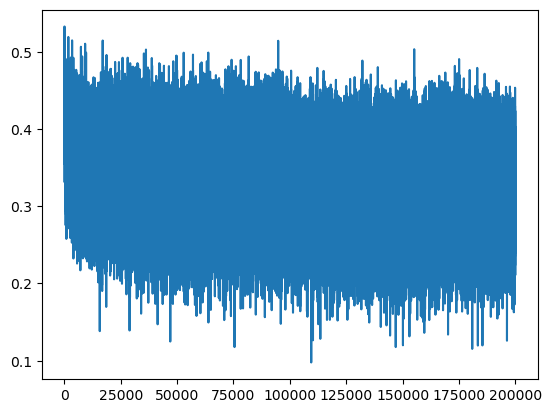

In [6]:
plt.plot(lossi)

In [7]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    emb = C[x]  # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1  # IMPL: bias=False
    # IMPL inference time: use buffers from training
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)  # (N, n_hidden)
    logits = h @ W2 + b2  # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 2.0674145221710205
val 2.1056840419769287


### loss log

step | train | val
-------- | ------------------ | ----------------
original | 2.1245384216308594 | 2.168196439743042
fix softmax confidently wrong | 2.07 | 2.13
fix tanh layer too saturated at init | 2.0355966091156006 | 2.1026785373687744
use semi-principled "kaiming init" instead of hacky init | 2.0376641750335693 | 2.106989622116089
add batch norm layer | 2.0668270587921143 |  2.104844808578491

# MLP: Deeper Network

Formalizing abstractions to resemble PyTorch nn.Module interfaces.

Note: `.out` attr is not a part of PyTorch, only cached here for visualizations.

In [8]:
# https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        # torch initializes to uniform distribution instead
        # fan_in scaling no longer needed due to BatchNorm layers
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


# https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
# Training uses unbiased (Bessel's correction) bnvar vs inference uses biased buffer running_var (inconsistent!)
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        # affine=True, track_running_stats=True, dtype=float32

        self.eps = eps  # for numerical stability of batch std
        self.momentum = momentum  # defines moving average buffers
        self.training = True  # training mode vs eval/inference mode
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)  # gain
        self.beta = torch.zeros(dim)  # bias
        # buffers (trained with a running 'momentum update') for inference
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)  # batch mean
            xvar = x.var(0, keepdim=True)  # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize to unit variance
        self.out = self.gamma * xhat + self.beta  # shift and scale
        # update the buffers
        if self.training:
            with torch.no_grad():
                # exponential moving avg
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * xmean
                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [10]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []  # update to data ratio (a check on learning rate)

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # [batch_size, n_hidden] concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append(
            [((lr * p.grad).std() / p.data.std()).log10().item() for p in parameters]
        )

    if i >= 5000:
        break  # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


layer 2 (      Tanh): mean +0.00, std 0.63, saturated: 3.91%
layer 5 (      Tanh): mean -0.01, std 0.65, saturated: 3.72%
layer 8 (      Tanh): mean +0.00, std 0.66, saturated: 3.47%
layer 11 (      Tanh): mean +0.01, std 0.67, saturated: 2.75%
layer 14 (      Tanh): mean +0.00, std 0.67, saturated: 2.12%


Text(0.5, 1.0, 'activation distribution')

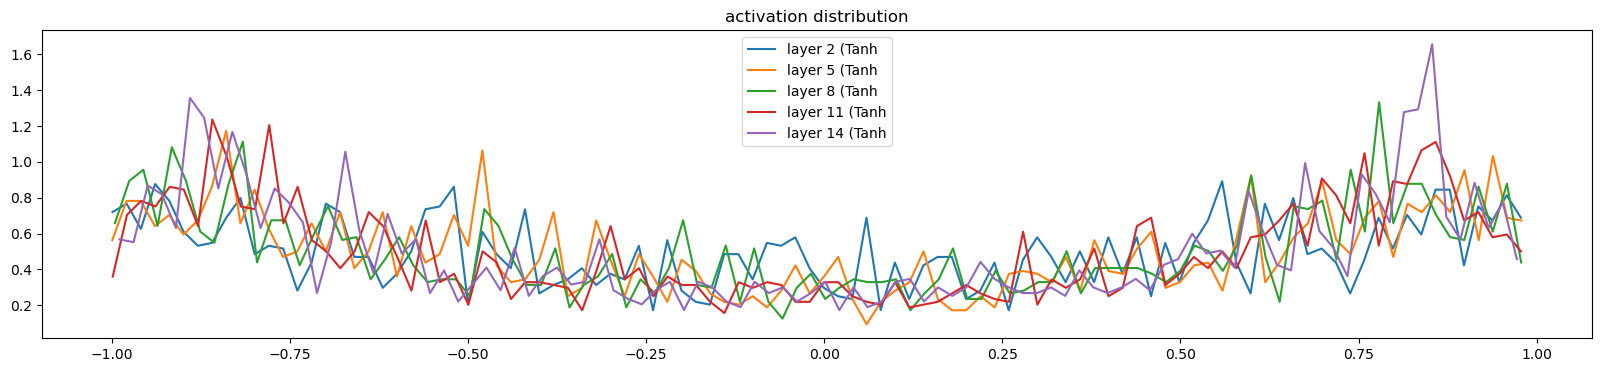

In [11]:
# visualize tanh layer histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(
            "layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%"
            % (
                i,
                layer.__class__.__name__,
                t.mean(),
                t.std(),
                (t.abs() > 0.97).float().mean() * 100,
            )
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("activation distribution")

layer 2 (      Tanh): mean -0.000000, std 2.375948e-03
layer 5 (      Tanh): mean +0.000000, std 2.196896e-03
layer 8 (      Tanh): mean +0.000000, std 2.070738e-03
layer 11 (      Tanh): mean +0.000000, std 1.975680e-03
layer 14 (      Tanh): mean -0.000000, std 2.077292e-03


Text(0.5, 1.0, 'gradient distribution')

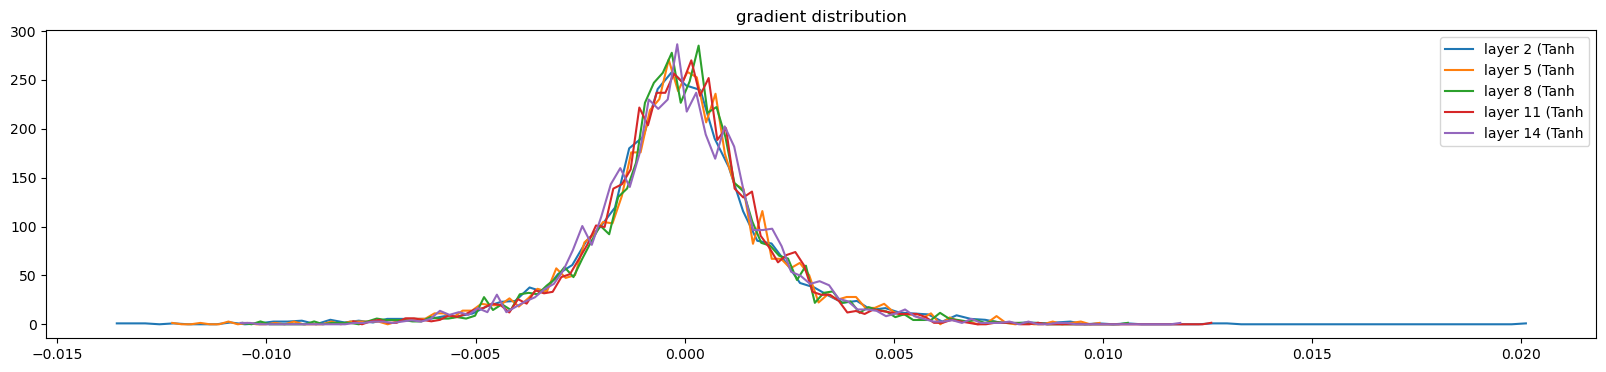

In [12]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(
            "layer %d (%10s): mean %+f, std %e"
            % (i, layer.__class__.__name__, t.mean(), t.std())
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("gradient distribution")

weight   (27, 10) | mean +0.000000 | std 8.963722e-03 | grad:data ratio 8.939089e-03
weight  (30, 100) | mean +0.000192 | std 8.259417e-03 | grad:data ratio 4.118933e-02
weight (100, 100) | mean -0.000066 | std 5.661872e-03 | grad:data ratio 5.042585e-02
weight (100, 100) | mean -0.000016 | std 5.448986e-03 | grad:data ratio 4.938331e-02
weight (100, 100) | mean +0.000008 | std 5.105984e-03 | grad:data ratio 4.691541e-02
weight (100, 100) | mean -0.000025 | std 4.550774e-03 | grad:data ratio 4.221905e-02
weight  (100, 27) | mean -0.000058 | std 9.337256e-03 | grad:data ratio 7.377045e-02


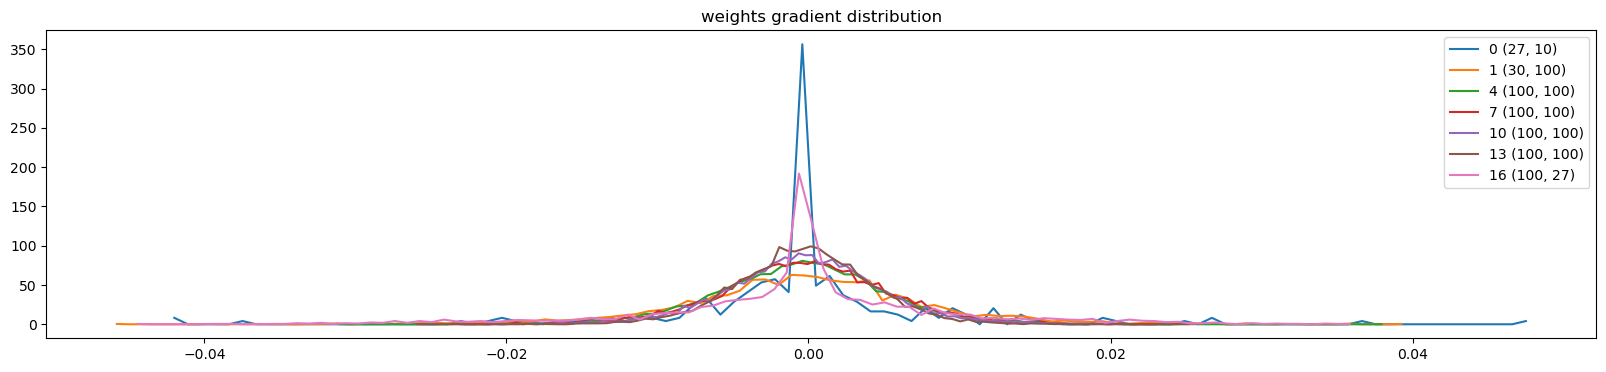

In [13]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(
            "weight %10s | mean %+f | std %e | grad:data ratio %e"
            % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std())
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {tuple(p.shape)}")
plt.legend(legends)
plt.title("weights gradient distribution");

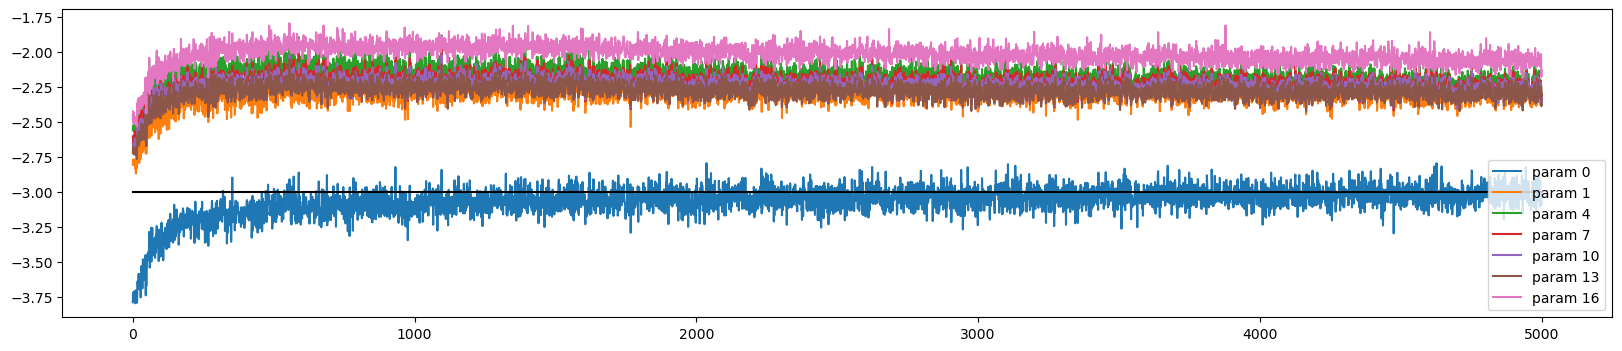

In [14]:
# -1 would be way too large
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append("param %d" % i)
plt.plot([0, len(ud)], [-3, -3], "k")  # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [15]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    emb = C[x]  # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())


# put layers into eval mode
for layer in layers:
    layer.training = False
split_loss("train")
split_loss("val")

train 2.2495529651641846
val 2.2571723461151123


In [16]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]  # (1,block_size,n_embd)
        x = emb.view(emb.shape[0], -1)  # concatenate the vectors
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print("".join(itos[i] for i in out))  # decode and print the generated word

mria.
mmyanniee.
mad.
ryah.
rethan.
ejdrlei.
adered.
eli.
jemi.
jen.
eden.
estanaraelyn.
malara.
nyshubergshimiest.
jair.
jelionn.
puranu.
zendder.
yarulyeh.
yuma.


# Extra

In [18]:
# BatchNorm forward pass as a widget

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np


def normshow(x0):

    g = torch.Generator().manual_seed(2147483647 + 1)
    x = torch.randn(5, generator=g) * 5
    x[0] = x0  # override the 0th example with the slider
    mu = x.mean()
    sig = x.std()
    y = (x - mu) / sig

    plt.figure(figsize=(10, 5))
    # plot 0
    plt.plot([-6, 6], [0, 0], "k")
    # plot the mean and std
    xx = np.linspace(-6, 6, 100)
    plt.plot(xx, stats.norm.pdf(xx, mu, sig), "b")
    xx = np.linspace(-6, 6, 100)
    plt.plot(xx, stats.norm.pdf(xx, 0, 1), "r")
    # plot little lines connecting input and output
    for i in range(len(x)):
        plt.plot([x[i], y[i]], [1, 0], "k", alpha=0.2)
    # plot the input and output values
    plt.scatter(x.data, torch.ones_like(x).data, c="b", s=100)
    plt.scatter(y.data, torch.zeros_like(y).data, c="r", s=100)
    plt.xlim(-6, 6)
    # title
    plt.title("input mu %.2f std %.2f" % (mu, sig))


interact(normshow, x0=(-30, 30, 0.5));

interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…

In [19]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000, 1), requires_grad=True, generator=g)  # a.grad = b.T @ c.grad
b = torch.randn((1000, 1000), requires_grad=True, generator=g)  # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print("a std:", a.std().item())
print("b std:", b.std().item())
print("c std:", c.std().item())
print("-----")
print("c grad std:", c.grad.std().item())
print("a grad std:", a.grad.std().item())
print("b grad std:", b.grad.std().item())

a std: 0.9875972270965576
b std: 1.0006722211837769
c std: 31.01241683959961
-----
c grad std: 0.9782556295394897
a grad std: 30.8818302154541
b grad std: 0.9666601419448853


In [20]:
# Linear + BatchNorm: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g)  # / n**0.5
x = w @ inp
# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print("inp std: ", inp.std().item())
print("w std: ", w.std().item())
print("x std: ", x.std().item())
print("out std: ", out.std().item())
print("------")
print("out grad std: ", out.grad.std().item())
print("x grad std: ", x.grad.std().item())
print("w grad std: ", w.grad.std().item())
print("inp grad std: ", inp.grad.std().item())

inp std:  0.9875972270965576
w std:  1.0006722211837769
x std:  31.01241683959961
out std:  1.0
------
out grad std:  0.9782556295394897
x grad std:  0.031543977558612823
w grad std:  0.031169468536973
inp grad std:  0.9953054189682007
